Here we will attempt to implement the 9 qubit shor code which will help to correct bit flip errors and phase flip errors. However note that we will have to make our own noise model to show the issue with this error correcting code. So we begin by doing just that:

In [3]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error, ReadoutError
from qiskit_aer.noise.errors import pauli_error
from qiskit_aer import AerSimulator
import numpy as np
from qiskit import QuantumCircuit, transpile, QuantumRegister,ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.circuit.library import XGate
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import time
from qiskit.circuit import Parameter
from qiskit_aer.noise import NoiseModel

#If you were wondering, I'm just adding more to this import list as to make things easier later. I just have to copy the entire code and
# I have everything I need

In [178]:
noise_model = NoiseModel()

# We will use a general error chance of p
error = 0.01
t1 = 50e3
t2=50e3
time = 100

p_1q = depolarizing_error(error, 1) # Error for 1 qubit gates
p_2q = depolarizing_error(error, 2) # Error for 2 qubit gates

# Adds gate times and everything, T1 says how long for any state to go to 0, T2 for phase issues, duration for how long each gate needs
# to be applied for. Everything is in nanoseconds, and I might try to fluctuate these to see how it affects performance. 
thermal_error_q1 = thermal_relaxation_error(t1=t1, t2=t2, time = time)
thermal_error_q2 = thermal_relaxation_error(t1=t1, t2=t2, time = time).tensor(thermal_relaxation_error(t1, t2, time)) #tensor is needed for larger dimensional matrices 

#combining errors so that they all work

combined_q1_error = p_1q.compose(thermal_error_q1)
combined_q2_error = p_2q.compose(thermal_error_q2)

noise_model.add_all_qubit_quantum_error(combined_q1_error, ['u1', 'u2', 'x', 'h'])
noise_model.add_all_qubit_quantum_error(combined_q2_error, ['cx'])

There are other options that we can add such as `bit_flip = pauli_error([('X', 0.01), ('I', 0.99)])` with `noise_model.add_all_qubit_quantum_error(bit_flip, ['x'])`. This adds an error on the `X` gate, where it might fail to be applied with a 1% chance. We can also add a readout error where we might not read the output properly by using `readout = ReadoutError([[0.95, 0.05], [0.1, 0.9]])  # [[P(0|0), P(1|0)], [P(0|1), P(1|1)]]` where P(0|0) is the probability that a 0 is read as a 0 and P(1|0) is the probability that a 0 is read as a 1. 

To add these errors, you have to use `noise_model.add_all_qubit_readout_error()` where the arguments is the error you are adding and an optional argument on the gates it should apply to. 

You can also combine errors by first creating each instance separately then using the `compose()` function. 

Now we can simulate our quantum circuit using this noise model.

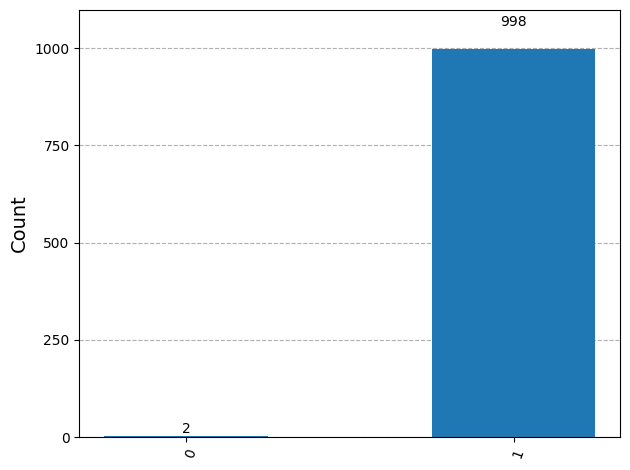

In [183]:
qubits = 1 #This will be LOGICAL qubits, so normal with no QEC

qc = QuantumCircuit(qubits)

qc.x(0)
qc.measure_all()
qc.draw("mpl")

simulator = AerSimulator(noise_model = noise_model)

qc_t = transpile(qc, simulator)

job = simulator.run(qc_t, shots = 1000).result()

plot_histogram(job.get_counts())

Now we will attempt to implement the bit flip correction code. 

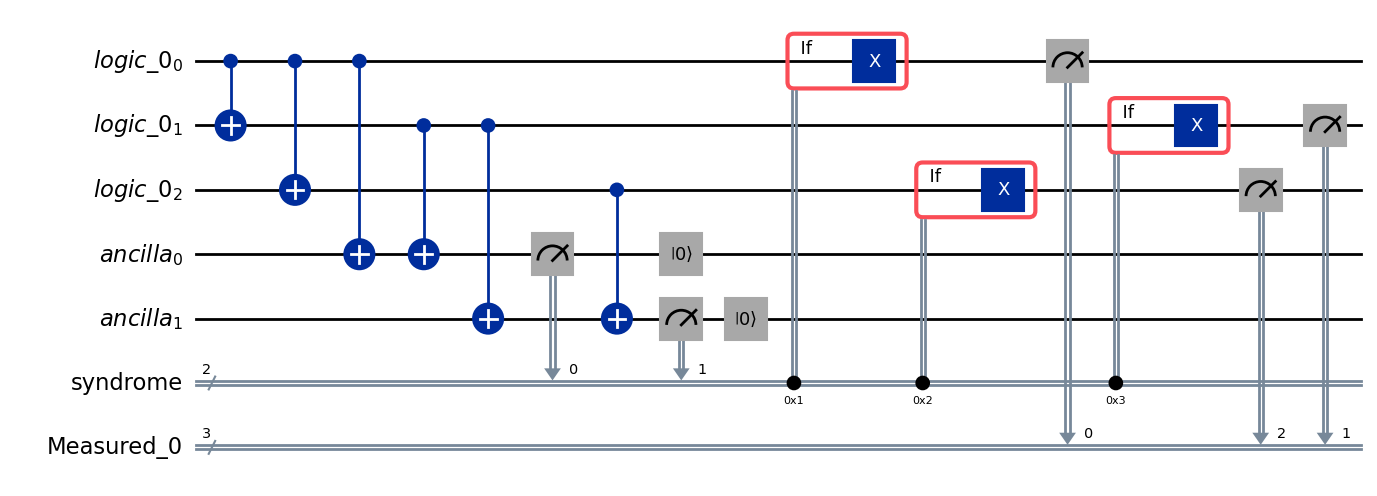

In [147]:
logical_qubit_0 = QuantumRegister(3, "logic_0")
ancilla = QuantumRegister(2,"ancilla")
classical = ClassicalRegister(2,"syndrome")
measured = ClassicalRegister(3, "Measured_0")
qc = QuantumCircuit(logical_qubit_0,ancilla,classical,measured)

#Entangles and combines all of the qubits
qc.cx(logical_qubit_0[0],logical_qubit_0[1])
qc.cx(logical_qubit_0[0],logical_qubit_0[2])

#Info for first bit of syndrome
qc.cx(logical_qubit_0[0],ancilla[0])
qc.cx(logical_qubit_0[1],ancilla[0])

#Info for second bit of syndrome
qc.cx(logical_qubit_0[1],ancilla[1])
qc.cx(logical_qubit_0[2],ancilla[1])

# Computes Syndrome
qc.measure(ancilla[0], classical[0]) # Classic 0 stores comparison between q1 and q0
qc.measure(ancilla[1], classical[1]) # Classic 1 stores comparison between q2 and q1

# Reset Ancilla
qc.reset(ancilla[0])
qc.reset(ancilla[1])

# Apply Changes as necessary
with qc.if_test((classical, 1)):
    qc.x(logical_qubit_0[0])
with qc.if_test((classical, 2)):
    qc.x(logical_qubit_0[2])
with qc.if_test((classical, 3)):
    qc.x(logical_qubit_0[1])

qc.measure(logical_qubit_0,measured)
qc.draw("mpl")

To carry out a gate that is controlled by a classical gate use the `if_test` method. This uses a tuple with the classical bits first, then the value the classical bits should be in base 10. Then while using a `with` statement proceed to add the gate on the desired qubits. I'm not going to use functions as this is just a small scale setup to show how this works, but I will increase it as necessary.

Now we will run the quantum error correction circuit by first running the gate, then the error correction. If we do it before, the effect wont be as good as there isn't enough time for the qubits to accumulate errors. 

{'011 00': 2, '000 11': 3, '000 00': 2, '110 01': 8, '111 01': 7, '111 11': 11, '001 10': 9, '110 00': 8, '011 10': 5, '101 00': 5, '111 10': 7, '111 00': 933}


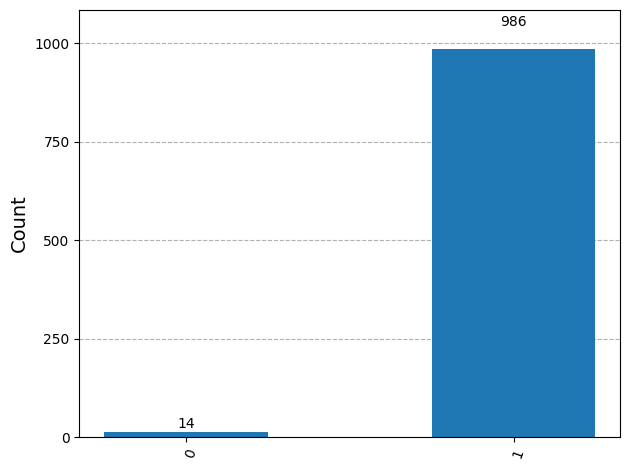

In [187]:
def logical_not(circuit, logical_qubit):
    circuit.x(logical_qubit[0])
    circuit.x(logical_qubit[1])
    circuit.x(logical_qubit[2])
    
logical_qubit_0 = QuantumRegister(3, "logic_0")
ancilla = QuantumRegister(2,"ancilla")
classical = ClassicalRegister(2,"syndrome")
measured = ClassicalRegister(3, "Measured_0")
qc = QuantumCircuit(logical_qubit_0,ancilla,classical,measured)

#Entangles and combines all of the qubits
qc.cx(logical_qubit_0[0],logical_qubit_0[1])
qc.cx(logical_qubit_0[0],logical_qubit_0[2])

#Applies the logical not gate
logical_not(qc,logical_qubit_0)

#Info for first bit of syndrome
qc.cx(logical_qubit_0[0],ancilla[0])
qc.cx(logical_qubit_0[1],ancilla[0])

#Info for second bit of syndrome
qc.cx(logical_qubit_0[1],ancilla[1])
qc.cx(logical_qubit_0[2],ancilla[1])

# Computes Syndrome
qc.measure(ancilla[0], classical[0]) # Classic 0 stores comparison between q1 and q0
qc.measure(ancilla[1], classical[1]) # Classic 1 stores comparison between q2 and q1

# Reset Ancilla
qc.reset(ancilla[0])
qc.reset(ancilla[1])
# Apply Changes as necessary
with qc.if_test((classical, 1)):
    qc.x(logical_qubit_0[0])
with qc.if_test((classical, 2)):
    qc.x(logical_qubit_0[2])
with qc.if_test((classical, 3)):
    qc.x(logical_qubit_0[1])

qc.measure(logical_qubit_0,measured)
qc.draw("mpl")


qc_t = transpile(qc, simulator)

job = simulator.run(qc_t, shots = 1000).result()

# we need to filter out the ancilla measurements, so lets do that:

print(job.get_counts())
values = {
    
}
for bitstring,count in job.get_counts().items():
    values['0'] = sum([c for k, c in job.get_counts().items() if k[0:3] == '000' or k[0:3] == '001' or k[0:3] == '010' or k[0:3] == '100'])
    values['1'] = sum([c for k, c in job.get_counts().items() if k[0:3] == '011' or k[0:3] == '101' or k[0:3] == '110' or k[0:3] == '111'])

plot_histogram(values)

Okay so I'm not sure why the error correcting code is performing WORSE than a normal circuit. It should be doing at least better in some scenarios, but it isn't. Could you try taking a look to see what's wrong? Thanks - A. Z.